# Tutorial pytorch

https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction.html

In [112]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,\
roc_auc_score

In [37]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, latent_space_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, latent_space_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_space_dim, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output

    def forward_embedding(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [38]:
# import dataset
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=10)

# init model
latent_space_dim = 15
autoencoder = LitAutoEncoder(latent_space_dim)

In [39]:
# train the model

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(accelerator="gpu", devices=8) (if you have GPUs)
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 51.2 K
1 | decoder | Sequential | 52.0 K
---------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     To

Training: 0it [00:00, ?it/s]

In [40]:
get_X_y_loader = DataLoader(dataset, batch_size=60000)

X,Y = list(get_X_y_loader)[0]

X.shape

torch.Size([60000, 1, 28, 28])

In [41]:
i = 55

outputs = autoencoder.forward(X[i].flatten())
outputs = outputs.reshape(28,28)

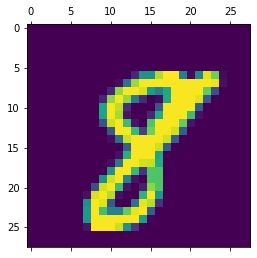

<Figure size 432x288 with 0 Axes>

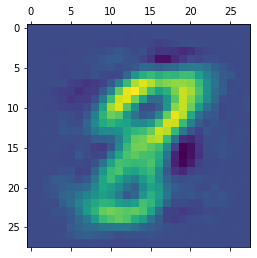

In [42]:
plt.matshow(X[i][0])
plt.figure()
plt.matshow(outputs.detach().numpy())

In [43]:
autoencoder.forward_embedding(X[:10].flatten(start_dim=1))

tensor([[ 1.0652e+00,  5.7774e-01,  8.8782e-01,  1.2906e+00,  4.1393e-01,
          4.2344e-01,  1.3260e-01,  2.4308e-01, -8.0100e-02, -8.7767e-01,
          3.5477e-02, -3.1764e-01, -1.6040e-01,  9.4677e-01,  4.5412e-01],
        [ 9.2933e-01, -7.1269e-01,  1.5203e-01,  8.4789e-01,  1.4557e-01,
          6.8219e-01, -9.9814e-01, -9.7807e-01,  4.8012e-01,  7.4799e-01,
          5.2460e-01,  2.0362e-01,  5.8928e-01,  2.2480e+00,  4.8297e-03],
        [-4.2706e-01,  6.8885e-01, -7.9994e-02, -9.3204e-02,  2.2164e-01,
          5.8952e-02,  1.5688e-01, -9.8718e-01,  1.3592e+00,  1.4906e-02,
          1.6534e-01,  1.4995e-01,  8.4817e-01,  2.9356e-02, -3.9766e-01],
        [ 5.1431e-01, -1.0181e+00, -4.6320e-01, -1.0944e+00,  8.5950e-01,
          4.4725e-01,  7.6085e-01,  7.9462e-01, -4.5343e-01,  4.1263e-01,
          1.0064e-01,  1.4273e+00, -5.9479e-01,  8.6152e-01,  4.9957e-01],
        [-8.4635e-01, -1.0140e-01,  1.6315e-01,  1.4602e-01,  2.5892e-02,
          2.3095e-02,  1.0114e-01,

## add classifier

In [44]:
class LinearClassifier(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer0 = nn.Linear(input_size, output_size)
        self.activation0 = nn.Softmax(dim=1)
        self.loss = nn.CrossEntropyLoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.layer0(x)
        output = self.activation0(output)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [45]:
# define the linear classifier
lin_class = LinearClassifier(latent_space_dim, 10)

In [46]:
# create its dataset
X_propag = X.flatten(start_dim=1)
embeddings = autoencoder.forward_embedding(X_propag)
embeddings.detach_()
print(embeddings[:10])

# apparently no need
Y_one_hot = F.one_hot(Y).type(torch.FloatTensor)
print(Y_one_hot[:5])

tensor([[ 1.0652e+00,  5.7774e-01,  8.8782e-01,  1.2906e+00,  4.1393e-01,
          4.2344e-01,  1.3260e-01,  2.4308e-01, -8.0100e-02, -8.7767e-01,
          3.5477e-02, -3.1764e-01, -1.6040e-01,  9.4677e-01,  4.5412e-01],
        [ 9.2933e-01, -7.1269e-01,  1.5203e-01,  8.4789e-01,  1.4557e-01,
          6.8219e-01, -9.9814e-01, -9.7807e-01,  4.8012e-01,  7.4799e-01,
          5.2460e-01,  2.0362e-01,  5.8928e-01,  2.2480e+00,  4.8297e-03],
        [-4.2706e-01,  6.8885e-01, -7.9994e-02, -9.3204e-02,  2.2164e-01,
          5.8953e-02,  1.5688e-01, -9.8718e-01,  1.3592e+00,  1.4906e-02,
          1.6534e-01,  1.4995e-01,  8.4817e-01,  2.9356e-02, -3.9766e-01],
        [ 5.1431e-01, -1.0181e+00, -4.6320e-01, -1.0944e+00,  8.5950e-01,
          4.4725e-01,  7.6085e-01,  7.9462e-01, -4.5343e-01,  4.1263e-01,
          1.0064e-01,  1.4273e+00, -5.9479e-01,  8.6152e-01,  4.9957e-01],
        [-8.4635e-01, -1.0140e-01,  1.6315e-01,  1.4602e-01,  2.5892e-02,
          2.3095e-02,  1.0114e-01,

In [47]:
# train the linear classifier on the latent space embedding

train_set = TensorDataset(embeddings, Y)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=5)
trainer_lin.fit(model=lin_class, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | layer0      | Linear           | 160   
1 | activation0 | Softmax          | 0     
2 | loss        | CrossEntropyLoss | 0     
-------------------------------------------------
160       Trainable params
0         Non-trainable params
160       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [48]:
Y_pred = lin_class.forward(embeddings)
Y_pred = pd.DataFrame(Y_pred.detach().numpy())
Y_pred["prediction"] = Y_pred.apply(np.argmax, axis=1)
Y_pred

,0,1,2,3,4,5,6,7,8,9,prediction
0,0.000236,1.492389e-06,3.926176e-04,2.706233e-01,1.020969e-07,0.726693,2.578622e-06,4.179239e-06,1.925494e-03,1.217575e-04,5
1,0.999955,5.939976e-15,1.386806e-10,1.544870e-10,7.218954e-12,0.000045,9.624676e-09,7.910735e-12,1.270164e-09,9.098839e-10,0
2,0.001181,1.323174e-06,2.479436e-04,1.659138e-03,9.501346e-01,0.001153,2.269879e-04,9.394144e-05,1.066469e-03,4.423593e-02,4
3,0.000085,9.832885e-01,4.827475e-04,3.962046e-05,6.308584e-05,0.000268,3.174072e-06,4.448861e-05,1.571888e-02,6.767474e-06,1
4,0.000001,1.940176e-08,1.994107e-09,3.130602e-09,7.228050e-02,0.000083,4.772648e-06,5.963410e-04,1.104990e-04,9.269239e-01,9
...,...,...,...,...,...,...,...,...,...,...,...
59995,0.000005,2.475223e-04,1.198919e-04,1.793856e-04,4.379055e-06,0.000272,2.449819e-07,1.526841e-08,9.991409e-01,3.122910e-05,8
59996,0.000001,3.703338e-07,4.611711e-05,9.999015e-01,1.248182e-08,0.000032,2.129452e-10,5.628963e-11,1.882409e-05,1.317905e-08,3
59997,0.000004,2.348071e-07,2.067665e-09,1.165918e-04,1.129460e-05,0.998151,8.309184e-09,3.993783e-06,6.953017e-04,1.017734e-03,5
59998,0.188639,3.198406e-07,1.245405e-03,1.171091e-06,1.081957e-03,0.004701,8.041490e-01,1.209496e-06,5.986405e-07,1.803149e-04,6


0.84945


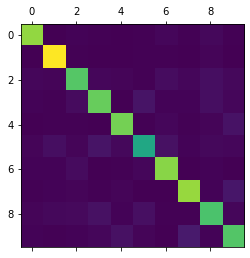

In [49]:
print(accuracy_score(Y, Y_pred.prediction))
conf_mat = confusion_matrix(Y, Y_pred.prediction)
plt.matshow(conf_mat)

## Get the embeddings

In [81]:
# because the embeddings are not calculated through Visualization, each element is present twice
dir_path = '/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10'

train_embeddings = pd.read_csv(dir_path+'/train_embeddings.csv', index_col=0)
val_embeddings = pd.read_csv(dir_path+'/val_embeddings.csv', index_col=0)

print(train_embeddings.shape)
print(val_embeddings.shape)


embeddings = pd.concat([train_embeddings, val_embeddings], axis=0, ignore_index=True)
embeddings

(880, 5)
(220, 5)


,subject,dim1,dim2,dim3,dim4
0,144226,-2.207053,2.572717,-3.648947,-0.379905
1,144226,-2.268051,2.614371,-3.520722,-0.138869
2,303624,12.872168,6.815033,-5.646133,14.380918
3,303624,12.459433,8.353728,-4.972514,14.725413
4,480141,3.699481,-2.619190,-10.280997,4.794017
...,...,...,...,...,...
1095,212015,8.657934,5.084440,-3.079031,17.102121
1096,158035,0.528529,3.882899,-2.446297,4.086941
1097,158035,-0.486430,2.983658,-2.467060,2.725870
1098,239944,11.371716,8.044619,-2.493785,18.786053


In [82]:
# take the mean of the two representations
embeddings = embeddings.groupby(['subject']).mean()
embeddings

,dim1,dim2,dim3,dim4
subject,,,,
100307,2.647795,-3.684141,-11.374614,3.588052
100610,14.752218,11.085659,-3.201238,19.024449
101107,12.183602,5.672369,-6.975614,11.922921
101309,3.039796,-3.359846,-9.495158,6.162879
102008,5.510081,-1.798072,-9.784253,5.703923
...,...,...,...,...
973770,11.549474,5.100856,-4.246515,19.545314
987074,13.200897,4.419208,-6.361612,15.696317
987983,0.843702,-5.026104,-14.056771,-0.473112


In [83]:
# generate fake labels

labels = np.random.randint(0,2,550)
labels = torch.from_numpy(labels).type(torch.FloatTensor)
print(labels[:10])

# change dtype of embeddings for the next cells to work
embeddings = torch.from_numpy(embeddings.values).type(torch.FloatTensor)
embeddings

tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0.])


tensor([[  2.6478,  -3.6841, -11.3746,   3.5881],
        [ 14.7522,  11.0857,  -3.2012,  19.0245],
        [ 12.1836,   5.6724,  -6.9756,  11.9229],
        ...,
        [  0.8437,  -5.0261, -14.0568,  -0.4731],
        [ 10.5656,   2.6737,  -7.1719,  11.9302],
        [ 14.8978,  11.3085,  -2.9059,  19.4948]])

In [108]:
# create classifier

class BinaryClassifier(pl.LightningModule):
    def __init__(self, input_size, output_size, activation=None):
        super().__init__()
        self.layer0 = nn.Linear(input_size, output_size)
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
        self.loss = nn.MSELoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.layer0(x)
        if self.activation:
            output = self.activation(output)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [109]:
bin_class = BinaryClassifier(4,1)

train_set = TensorDataset(embeddings, labels)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=5)
trainer_lin.fit(model=bin_class, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type    | Params
-----------------------------------
0 | layer0 | Linear  | 5     
1 | loss   | MSELoss | 0     
-----------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)
/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


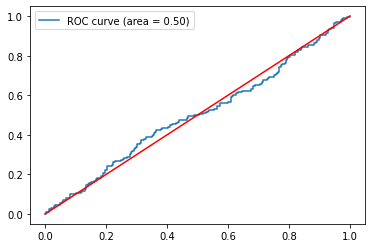

In [116]:
labels = labels.detach_().numpy()

labels_pred = bin_class.forward(embeddings)
labels_pred = labels_pred.detach().numpy()

curves = roc_curve(labels, labels_pred)
roc_auc = roc_auc_score(labels.detach_().numpy(), labels_pred)

plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color='r')
plt.legend()